In [45]:
%pip install flwr[simulation] torch torchvision matplotlib flwr-datasets[vision] torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [46]:


import json
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Parameters
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from torch.utils.data import DataLoader

from EntropyWeightedFedAvg import EntropyWeightedFedAvg

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) for training.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU for training.")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU for training.")

print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

NUM_CLIENTS = 25
BATCH_SIZE = 32
NUM_ROUNDS = 10
NUM_EPOCHS = 10
NUM_PARTITIONS = NUM_CLIENTS
print(
    f"Number of clients: {NUM_CLIENTS}, BATCH_SIZE: {BATCH_SIZE}, NUM_ROUNDS: {NUM_ROUNDS}, NUM_EPOCHS: {NUM_EPOCHS}, NUM_PARTITIONS: {NUM_PARTITIONS}")

Using Apple Silicon GPU (MPS) for training.
Training on mps using PyTorch 2.7.1 and Flower 1.20.0
Number of clients: 25, BATCH_SIZE: 32, NUM_ROUNDS: 10, NUM_EPOCHS: 10, NUM_PARTITIONS: 25


Let's load the CIFAR-10 dataset and partition it into `NUM_PARTITIONS` partitions.
Each partition will be assigned to a different client.
We will also apply class skewing to the data, so that some clients will have low entropy datasets, while others will have high entropy datasets.



In [47]:
def load_datasets(partition_id: int, num_partitions: int, skew_percentage: float = 0.5):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)

    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    # Determine how many clients should have skewed data
    num_skewed_clients = int(num_partitions * skew_percentage)

    # Apply class skewing to selected clients only
    if partition_id < num_skewed_clients:
        train_data = partition_train_test["train"]

        # Each skewed client gets 1-2 dominant classes
        if partition_id < num_skewed_clients // 2:
            # First half of skewed clients get single class (very low entropy)
            dominant_class = partition_id % 10
            train_data = train_data.filter(lambda x: x["label"] == dominant_class)
            print(f"Client {partition_id}: Training on class [{dominant_class}] (SKEWED - Low Entropy)")
        else:
            # Second half get two classes (medium entropy)
            class1 = (partition_id * 2) % 10
            class2 = (class1 + 1) % 10
            train_data = train_data.filter(lambda x: x["label"] in [class1, class2])
            print(f"Client {partition_id}: Training on classes [{class1}, {class2}] (SKEWED - Medium Entropy)")

        # Update the partition with skewed training data
        partition_train_test["train"] = train_data
    else:
        # These clients keep the normal data distribution (high entropy)
        print(f"Client {partition_id}: Training on all classes (NORMAL - High Entropy)")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )

    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader


Let's define the neural network architecture.
This is a simple CNN with two convolutional layers followed by three fully connected layers.

In [48]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch + 1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Let's define a function to compute the entropy of a dataset.
The entropy is computed for each column in the dataset, and then the average entropy is returned.

In [49]:
import pandas as pd
def _get_column_entropy_paper(column) -> float:
    counts = column.value_counts(dropna=False)
    total = counts.sum()
    probs = counts / total
    return -sum(np.log2(probs))
def _get_column_entropy(column) -> float:
    column_probability = column.value_counts(normalize=True, dropna=False)
    column_probability = column_probability[column_probability > 0]
    return -sum(column_probability * np.log2(column_probability))

def compute_entropy(dataset) -> float:
    dataset = pd.DataFrame(dataset)
    entropies = [_get_column_entropy(dataset[column]) for column in dataset.columns]
    return np.mean(entropies)

In [50]:
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader: DataLoader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id} fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=NUM_EPOCHS)

        # Compute entropy of the training dataset
        entropy = compute_entropy(self.trainloader.dataset)

        return get_parameters(self.net), len(self.trainloader), {"entropy": float(entropy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [51]:

params = get_parameters(Net())


# The `evaluate` function will be called by Flower after every round
def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[
    Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    # Compute entropy of the test set

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    en = compute_entropy(testloader.dataset)

    return loss, {"accuracy": accuracy, "entropy": compute_entropy(testloader.dataset)}


In [52]:


# Vanilla FedAvg for comparison
class VanillaFedAvg(FedAvg):
    """Standard FedAvg strategy with plotting functionality for comparison."""

    def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_name = file_name
        self.num_rounds = num_rounds
        self.loss_list = []
        self.metrics_list = []

    def evaluate(self, server_round: int, parameters: Parameters):
        """Evaluate model parameters using an evaluation function."""
        loss, metrics = super().evaluate(server_round, parameters)

        if loss is not None and metrics is not None:
            # Record results
            self.loss_list.append(loss)
            self.metrics_list.append(metrics)

            print(f"Round {server_round} - Vanilla FedAvg:")
            print(f"  Loss: {loss:.4f}")
            print(f"  Accuracy: {metrics.get('accuracy', 0.0):.4f}")

            # If last round, save results only (no plot generation)
            if server_round == self.num_rounds:
                with open(f"{self.file_name}_vanilla.json", "w") as f:
                    json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)

            return loss, metrics

        # ⚠️ Add a fallback to prevent crashing
        print(f"[Warning] Evaluation returned None at round {server_round}")
        return 0.0, {}


def server_fn_vanilla(context: Context) -> ServerAppComponents:
    """Server function for vanilla FedAvg strategy."""
    # Create the vanilla FedAvg strategy
    strategy = VanillaFedAvg(
        file_name="results_vanilla_fedavg",
        num_rounds=NUM_ROUNDS,
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,  # Pass the evaluation function
    )
    # Configure the server for training rounds
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)



In [53]:

def server_fn_entropy(context: Context) -> ServerAppComponents:
    """Server function for vanilla FedAvg strategy."""
    # Create the vanilla FedAvg strategy
    strategy = EntropyWeightedFedAvg(
        file_name="results_vanilla_fedavg",
        num_rounds=NUM_ROUNDS,
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,  # Pass the evaluation function
    )
    # Configure the server for training rounds
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)


print("Running Entropy-weighted simulation...")
server_entropy = ServerApp(server_fn=server_fn_entropy)
run_simulation(
    server_app=server_entropy,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config={"client_resources": {"num_cpus": 10, "num_gpus": 0}},
)


INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      


Running Entropy-weighted simulation...


INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.07214355716705323 / accuracy 0.1


INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


Round 0 - Entropy-Weighted FedAvg:
  Loss: 0.0721
  Accuracy: 0.1000
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.07319007813930511, accuracy 0.37333333333333335
(ClientAppActor pid=67940) Epoch 2: train loss 0.0509108230471611, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 0.008472062647342682, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 6.099533129599877e-05, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 3.7796322516214786e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 3.4769367940334917e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940

INFO :      aggregate_fit: received 25 results and 0 failures


Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9801, weight: 0.1433, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 6.9812, weight: 0.1432, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 4.7153, weight: 0.2121, examples: 11
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 4.6918, weight: 0.2131, examples: 

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 1 - Entropy-Weighted FedAvg:
  Loss: 0.0579
  Accuracy: 0.3494
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) 
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes 

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 18: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 18] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.039204347878694534, accuracy 0.7133333333333334
(ClientAppActor pid=67940) Epoch 2: train loss 0.00352141703478992, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 0.00014614513202104717, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 9.259546459361445e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 3.965150199292111e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 7.350097064318106e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 2.7342684560949237e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 1.306309549420348e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 10: train loss 0.007341956719756126, accuracy 0.9221902017291066
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9813, weight: 0.1432, examples: 50
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 6.9801, weight: 0.1433, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 4.7153, weight: 0.2121, examples: 11
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 6.9816, weight: 0.1432, examples: 50
Clie

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 2 - Entropy-Weighted FedAvg:
  Loss: 0.0468
  Accuracy: 0.4631
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 7: Training on classes [4, 5] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 7] evaluate, config: {}
(ClientAppActor pid=67940) Client 8: Training on classes [6, 7] (SKEW

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 11: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 11] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.016066372394561768, accuracy 0.8666666666666667
(ClientAppActor pid=67940) Epoch 2: train loss 0.0003915288543794304, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 2.655057869560551e-05, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 5.394278559833765e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 2.153048399122781e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 1.1525301033543656e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 6.424772323043726e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 4.904860020360502e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9:

INFO :      aggregate_fit: received 25 results and 0 failures


Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 3.6744, weight: 0.2722, examples: 6
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9801, weight: 0.1433, examples: 50
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 6.9823, weight: 0.1432, examples: 5

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 3 - Entropy-Weighted FedAvg:
  Loss: 0.0451
  Accuracy: 0.5101
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 7: Training on classes [4, 5] (SKEWED - Med

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 8: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 8] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.011411289684474468, accuracy 0.8866666666666667
(ClientAppActor pid=67940) Epoch 2: train loss 7.76339293224737e-05, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 4.7841344894550275e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 1.0835299235623097e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 2.8995768275308365e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 2.008832069577693e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 1.100153781408153e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 8.810011564719389e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: 

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 5: train loss 4.207282966461889e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 1.772778923658791e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 1.2744404420672595e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 8.823051178552532e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 6.208814573582799e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 6.453899636937876e-10, accuracy 1.0
Client entropy: 6.9812, weight: 0.1432, examples: 50
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 4.6918, weight: 0.2131, examples: 11
Client entropy: 6.9807, wei

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 4 - Entropy-Weighted FedAvg:
  Loss: 0.0471
  Accuracy: 0.5296
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 7: Training on classes [4, 5] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 7] evaluate, config: {}
(ClientAppActor pid=67940) Client 8: Training on classes [6, 7] (SKEWED - Med

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.012544152326881886, accuracy 0.88
(ClientAppActor pid=67940) Epoch 2: train loss 1.972802056116052e-05, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 4.781022653332911e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 1.1306212144290839e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 2.6313641043884672e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 1.3553106192887299e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 7.527289902498069e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 5.438892891618252e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 4.

(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 1s [Retry 1/5].
(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(
(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 2s [Retry 2/5].
(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 4s [Retry 3/5].
(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 8s [R

(ClientAppActor pid=67940) Client 17: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 17 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.040400609374046326, accuracy 0.560625
(ClientAppActor pid=67940) Epoch 2: train loss 0.03232349082827568, accuracy 0.635
(ClientAppActor pid=67940) Epoch 3: train loss 0.02746002748608589, accuracy 0.693125
(ClientAppActor pid=67940) Epoch 4: train loss 0.023901445791125298, accuracy 0.738125
(ClientAppActor pid=67940) Epoch 5: train loss 0.018695956096053123, accuracy 0.8175
(ClientAppActor pid=67940) Epoch 6: train loss 0.015051753260195255, accuracy 0.85375
(ClientAppActor pid=67940) Epoch 7: train loss 0.012212950736284256, accuracy 0.88125
(ClientAppActor pid=67940) Epoch 8: train loss 0.010243434458971024, accuracy 0.896875
(ClientAppActor pid=67940) Epoch 9: train loss 0.007545191794633865, accuracy 0.9375
(ClientAppActor pid=67940) Epoch 10: train loss 0.00530214561149478, accuracy 0.96
(Clie

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 5: train loss 2.2261462007122645e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 1.403531602051089e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 8.600907541733704e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 6.682242759126211e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 5.72495295614317e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 5.080213583141813e-09, accuracy 1.0
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9813, weight: 0.1432, examples: 50
Client entropy: 4.6308, weight: 0.2159, examples: 10
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 6.9824, w

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 5 - Entropy-Weighted FedAvg:
  Loss: 0.0513
  Accuracy: 0.5362
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entr

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 9: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 9] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.004928145091980696, accuracy 0.9407894736842105
(ClientAppActor pid=67940) Epoch 2: train loss 1.2278529304410313e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 0.0, accuracy 1.0
(ClientAppActo

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 10: train loss 0.0007255485979840159, accuracy 1.0
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9813, weight: 0.1432, examples: 50
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 4.6918, weight: 0.2131, examples: 11
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9812, weight: 0.1432, examples: 50
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 4.7153, weight: 0.2121, examples: 11
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 6.9

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 6 - Entropy-Weighted FedAvg:
  Loss: 0.0565
  Accuracy: 0.5325
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entr

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 22: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 22] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.01195985171943903, accuracy 0.88
(ClientAppActor pid=67940) Epoch 2: train loss 2.029890083576902e-06, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 7.177062144592128e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 1.103581226402639e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 2.7521940282326796e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 1.2553088568623139e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 7.698929271882093e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 4.718699320171993e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 4.85416

(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 1s [Retry 1/5].
(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 2s [Retry 2/5].
(ClientAppActor pid=67940) HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/cifar10/resolve/main/README.md
(ClientAppActor pid=67940) Retrying in 4s [Retry 3/5].


(ClientAppActor pid=67940) Client 17: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 17 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.04011090099811554, accuracy 0.59375
(ClientAppActor pid=67940) Epoch 2: train loss 0.02575720101594925, accuracy 0.719375
(ClientAppActor pid=67940) Epoch 3: train loss 0.019082525745034218, accuracy 0.804375
(ClientAppActor pid=67940) Epoch 4: train loss 0.013968280516564846, accuracy 0.859375
(ClientAppActor pid=67940) Epoch 5: train loss 0.009608431719243526, accuracy 0.91875
(ClientAppActor pid=67940) Epoch 6: train loss 0.006167721934616566, accuracy 0.9625
(ClientAppActor pid=67940) Epoch 7: train loss 0.004582114052027464, accuracy 0.970625
(ClientAppActor pid=67940) Epoch 8: train loss 0.0032269442453980446, accuracy 0.98375
(ClientAppActor pid=67940) Epoch 9: train loss 0.0021161376498639584, accuracy 0.990625
(ClientAppActor pid=67940) Epoch 10: train loss 0.0014152145013213158, accuracy 0.

INFO :      aggregate_fit: received 25 results and 0 failures


Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 6.9801, weight: 0.1433, examples: 50
Client entropy: 4.6308, weight: 0.2159, examples: 10
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9812, weight: 0.1432, examples: 50
Client entropy: 4.6918, weight: 0.2131, examples: 11
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9813, weight: 0.1432, examples: 

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 7 - Entropy-Weighted FedAvg:
  Loss: 0.0610
  Accuracy: 0.5357
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 7: Training on classes [4, 5] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 7] evaluate, config: {}
(ClientAppActor pid=67940) Client 8: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 8] evaluate, config: {}
(ClientAppActor pid=67940) Client 9: Training on classes [8, 

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.018998922780156136, accuracy 0.8280254777070064
(ClientAppActor pid=67940) Epoch 2: train loss 2.621890757836809e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 7.35566163534429e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 2.3727962303321526e-11, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 0.0, 

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 4: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 0.0, accuracy 1.0
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 3.6744, weight: 0.2722, examples: 6
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 4.6918, weight: 0.2131, examples: 11
Client entropy: 3.6144, weight: 0.2767, examples: 5
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 6

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 8 - Entropy-Weighted FedAvg:
  Loss: 0.0650
  Accuracy: 0.5346
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 7: Training on classes [4, 5] (SKEWED - Med

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 13: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 13] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.016130603849887848, accuracy 0.88
(ClientAppActor pid=67940) Epoch 2: train loss 7.418630616484734e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 1.4776778911596011e-08, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 5.373447242718044e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 1.738468535794624e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 7.450579736500984e-11, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 2.483526752306009e-11, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(Client

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=67940) Epoch 6: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 10: train loss 0.0, accuracy 1.0
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 3.6744, weight: 0.2722, examples: 6
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 3.6240, weight: 0.2759, examples: 5
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 4.6918, weight: 0.2131, examples: 11
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 6.9813, weight: 0.1432, examples: 50
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9816, weight: 0.1432, 

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 9 - Entropy-Weighted FedAvg:
  Loss: 0.0686
  Accuracy: 0.5361
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0] evaluate, config: {}
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entr

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 25 clients (out of 25)


(ClientAppActor pid=67940) Client 17: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=67940) [Client 17] evaluate, config: {}
(ClientAppActor pid=67940) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 0 fit, config: {}
(ClientAppActor pid=67940) Epoch 1: train loss 0.012226236052811146, accuracy 0.8933333333333333
(ClientAppActor pid=67940) Epoch 2: train loss 3.3558515610820905e-07, accuracy 1.0
(ClientAppActor pid=67940) Epoch 3: train loss 5.684991144505602e-09, accuracy 1.0
(ClientAppActor pid=67940) Epoch 4: train loss 3.9736414159108335e-10, accuracy 1.0
(ClientAppActor pid=67940) Epoch 5: train loss 6.095929316884963e-11, accuracy 1.0
(ClientAppActor pid=67940) Epoch 6: train loss 4.967053504612018e-11, accuracy 1.0
(ClientAppActor pid=67940) Epoch 7: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 8: train loss 0.0, accuracy 1.0
(ClientAppActor pid=67940) Epoch 9: train loss 0.0, accuracy 1.0
(ClientApp

INFO :      aggregate_fit: received 25 results and 0 failures


Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9824, weight: 0.1432, examples: 50
Client entropy: 6.9817, weight: 0.1432, examples: 50
Client entropy: 4.7153, weight: 0.2121, examples: 11
Client entropy: 6.9813, weight: 0.1432, examples: 50
Client entropy: 6.9812, weight: 0.1432, examples: 50
Client entropy: 4.6832, weight: 0.2135, examples: 11
Client entropy: 4.6310, weight: 0.2159, examples: 10
Client entropy: 6.9823, weight: 0.1432, examples: 50
Client entropy: 3.6473, weight: 0.2742, examples: 5
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9811, weight: 0.1432, examples: 50
Client entropy: 4.6425, weight: 0.2154, examples: 10
Client entropy: 3.6744, weight: 0.2722, examples: 6
Client entropy: 6.9816, weight: 0.1432, examples: 50
Client entropy: 6.9807, weight: 0.1433, examples: 50
Client entropy: 6.9806, weight: 0.1433, examples: 50
Client entropy: 4.6308, weight: 0.2159, examples: 10
Client entropy: 3.6144, weight: 0.2767, examples

INFO :      configure_evaluate: strategy sampled 25 clients (out of 25)


Round 10 - Entropy-Weighted FedAvg:
  Loss: 0.0697
  Accuracy: 0.5369
(ClientAppActor pid=67940) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 1] evaluate, config: {}
(ClientAppActor pid=67940) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 2] evaluate, config: {}
(ClientAppActor pid=67940) Client 3: Training on class [3] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 3] evaluate, config: {}
(ClientAppActor pid=67940) Client 4: Training on class [4] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 4] evaluate, config: {}
(ClientAppActor pid=67940) Client 6: Training on classes [2, 3] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 6] evaluate, config: {}
(ClientAppActor pid=67940) Client 8: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=67940) [Client 8] evaluate, config: {}
(ClientAppActor pid=67940) Client 10: Training on classes [0, 1] (SK

INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1321.53s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06045859394073484
INFO :      		round 2: 0.048571870201826094
INFO :      		round 3: 0.04635827559232711
INFO :      		round 4: 0.04784672403931618
INFO :      		round 5: 0.051935479497909554
INFO :      		round 6: 0.0571935020327568
INFO :      		round 7: 0.06152726035118103
INFO :      		round 8: 0.06545257593393328
INFO :      		round 9: 0.06914984425902365
INFO :      		round 10: 0.07047444348335266
INFO :      	History (metrics, distributed, fit):
INFO :      	{'avg_entropy': [(1, 5.622998317012899),
INFO :      	                 (2, 5.622998317012899),
INFO :      	                 (3, 5.622998317012899),
INFO :      	                 (4, 5.622998317012898),
INFO :      	                 (5, 5.622998317012899),
INFO :      	                 (6, 5.622998317012898),
I

(ClientAppActor pid=67940) Client 5: Training on class [5] (SKEWED - Low Entropy)
(ClientAppActor pid=67940) [Client 5] evaluate, config: {}


In [ ]:
print("Running Vanilla FedAvg simulation...")
server_vanilla = ServerApp(server_fn=server_fn_vanilla)
run_simulation(
    server_app=server_vanilla,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config={"client_resources": {"num_cpus": 10, "num_gpus": 0}},
)


INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Running Vanilla FedAvg simulation...


(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.07214355716705323 / accuracy 0.1


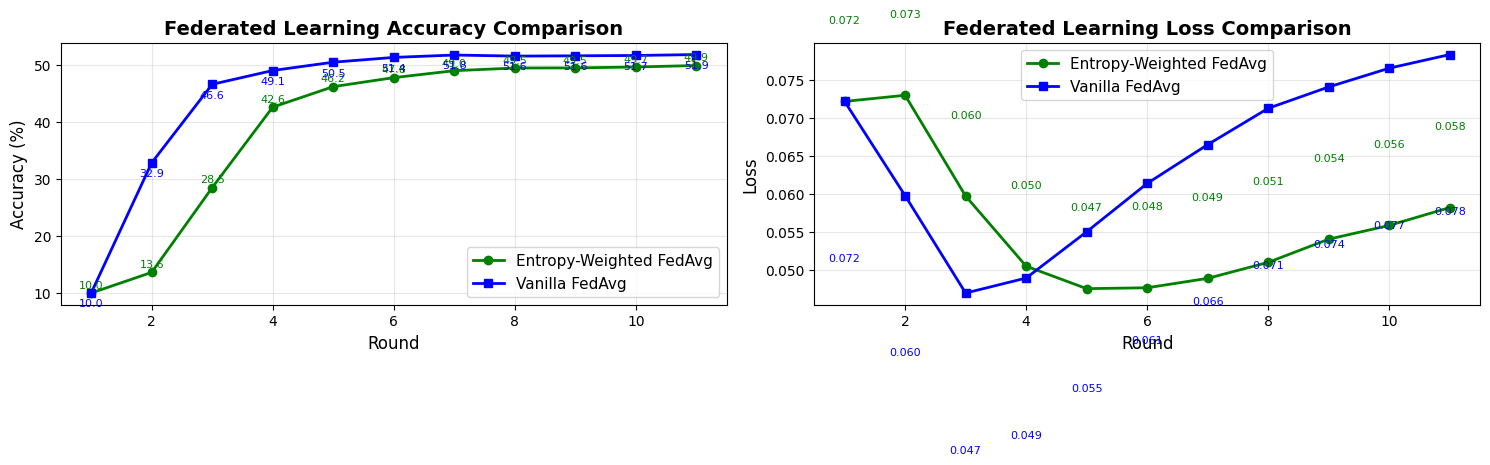


FEDERATED LEARNING COMPARISON SUMMARY
Final Accuracy:
  Entropy-Weighted FedAvg: 49.94%
  Vanilla FedAvg:          51.86%
  Improvement:             -1.92%

Final Loss:
  Entropy-Weighted FedAvg: 0.0582
  Vanilla FedAvg:          0.0783
  Improvement:             +0.0201


In [44]:
def create_comparison_plot():
    """Create a combined plot comparing Entropy-Weighted FedAvg vs Vanilla FedAvg."""

    # Load results from JSON files
    try:
        with open("results_vanilla_fedavg.json", "r") as f:
            entropy_results = json.load(f)

        with open("results_vanilla_fedavg_vanilla.json", "r") as f:
            vanilla_results = json.load(f)
    except FileNotFoundError:
        print("Error: Results files not found. Make sure both simulations have completed.")
        return

    # Extract data
    entropy_rounds = list(range(1, len(entropy_results["loss"]) + 1))
    vanilla_rounds = list(range(1, len(vanilla_results["loss"]) + 1))

    entropy_acc = [100.0 * metrics["accuracy"] for metrics in entropy_results["metrics"]]
    vanilla_acc = [100.0 * metrics["accuracy"] for metrics in vanilla_results["metrics"]]

    entropy_loss = entropy_results["loss"]
    vanilla_loss = vanilla_results["loss"]

    # Create the comparison plot
    plt.figure(figsize=(15, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(entropy_rounds, entropy_acc, 'g-o', label='Entropy-Weighted FedAvg', linewidth=2, markersize=6)
    plt.plot(vanilla_rounds, vanilla_acc, 'b-s', label='Vanilla FedAvg', linewidth=2, markersize=6)

    # Add value annotations
    for x, y in zip(entropy_rounds, entropy_acc):
        plt.text(x, y + 0.5, f"{y:.1f}", ha='center', va='bottom', fontsize=8, color='green')
    for x, y in zip(vanilla_rounds, vanilla_acc):
        plt.text(x, y - 1.0, f"{y:.1f}", ha='center', va='top', fontsize=8, color='blue')

    plt.grid(True, alpha=0.3)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xlabel("Round", fontsize=12)
    plt.title("Federated Learning Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(entropy_rounds, entropy_loss, 'g-o', label='Entropy-Weighted FedAvg', linewidth=2, markersize=6)
    plt.plot(vanilla_rounds, vanilla_loss, 'b-s', label='Vanilla FedAvg', linewidth=2, markersize=6)

    # Add value annotations
    for x, y in zip(entropy_rounds, entropy_loss):
        plt.text(x, y + 0.01, f"{y:.3f}", ha='center', va='bottom', fontsize=8, color='green')
    for x, y in zip(vanilla_rounds, vanilla_loss):
        plt.text(x, y - 0.02, f"{y:.3f}", ha='center', va='top', fontsize=8, color='blue')

    plt.grid(True, alpha=0.3)
    plt.ylabel("Loss", fontsize=12)
    plt.xlabel("Round", fontsize=12)
    plt.title("Federated Learning Loss Comparison", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)

    plt.tight_layout()
    plt.savefig("federated_learning_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 60)
    print("FEDERATED LEARNING COMPARISON SUMMARY")
    print("=" * 60)
    print(f"Final Accuracy:")
    print(f"  Entropy-Weighted FedAvg: {entropy_acc[-1]:.2f}%")
    print(f"  Vanilla FedAvg:          {vanilla_acc[-1]:.2f}%")
    print(f"  Improvement:             {entropy_acc[-1] - vanilla_acc[-1]:+.2f}%")
    print()
    print(f"Final Loss:")
    print(f"  Entropy-Weighted FedAvg: {entropy_loss[-1]:.4f}")
    print(f"  Vanilla FedAvg:          {vanilla_loss[-1]:.4f}")
    print(f"  Improvement:             {vanilla_loss[-1] - entropy_loss[-1]:+.4f}")
    print("=" * 60)


# Call the comparison plot function
create_comparison_plot()
